**Importing Necessary Packages**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

import cv2

from matplotlib import pyplot as plt
from matplotlib.image import * 

import tensorflow as tf

from tensorflow.keras.applications import VGG19

from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model

import scipy

 Important Constants for Processing Images 

In [2]:
# VGG19 Model Biases 

MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

# Amount of noise in Content Image

NOISE_RATIO = 0.6

IMAGE_WIDTH = 400
IMAGE_HEIGHT = 300
COLOR_CHANNELS = 3


Image Processing Functions

In [15]:

def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - MEANS
    
    return image

def save_image(path, image):
    """
    Same the output image 
    """
    
    # Un-normalize the image so that it looks good
    image = image + MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
#     scipy.misc.imsave(path, image)
    plt.imsave(path, image)
    
    

def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Initializes a noisy image by adding random noise to the content image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

def load_image(filename):
    
    """
    Converting an image to tensor after reading it  
    """
    
    image_file = tf.io.read_file("../input/styleimages/" + str(filename) + ".jpg")
            
    image_file = tf.image.decode_jpeg(image_file, channels=3)
        
    return image_file

Visualizing Content Image

(300, 400, 3)


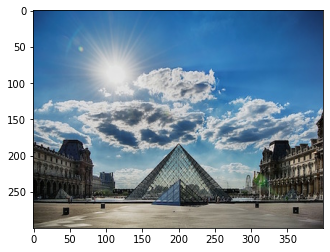

In [4]:
content_image = (load_image("louvre_small"))

print(content_image.shape)

plt.imshow(tf.reshape(content_image,shape=[300,400,3]))

Visualizing Style Image

(300, 400, 3)


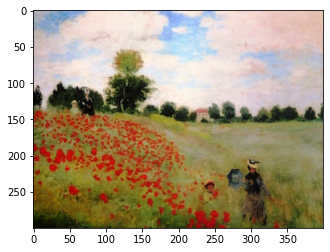

In [5]:
style_image = load_image("monet")

print(style_image.shape)

plt.imshow(style_image)

Helper Functions for VGG19 Model 

In [6]:
def create_model():
    
    """
    Creates a VGG19 model instance 
    """
    
    vgg19_model = VGG19(include_top=False,weights="imagenet",pooling="avg")
    
    return vgg19_model


def vgg_19_layers(layer_names_list):
    """
    Creates a VGG19 Model with activations of desired layers
    """
    vgg19_model = create_model()
    
    vgg19_model.trainable = False
    
    outputs = [vgg19_model.get_layer(name).output for name in layer_names_list]
    
    model = Model(inputs=[vgg19_model.input],outputs=outputs)
        
    return model

Helper Functions to calculate Style and Content Loss

In [7]:
def content_cost(content_activation, gen_activation):
    """
    Computes loss in content and output image
    """
    m, n_H, n_W, n_C = tf.Variable(content_activation).get_shape().as_list()
    
#     m, n_H, n_W, n_C = content_activation.get_shape().as_list()
    
    content_activation_unrolled = tf.reshape(content_activation, shape = [m,-1,n_C]) 
    
    gen_activation_unrolled = tf.reshape(gen_activation, shape = [m,-1,n_C])
    
    cost = tf.reduce_sum(tf.square(tf.subtract(content_activation_unrolled, gen_activation_unrolled))) / (4 * n_H * n_W * n_C)
    
    return cost

def gram_matrix(activation):
    """
    Generate Gram matrix to compute style loss
    """
    required_gram_matrix = tf.matmul(activation, tf.transpose(activation))
    
    return required_gram_matrix

def style_cost_of_one_layer(style_matrix, gen_matrix):
    """
    Computes loss in style for 1 layer 
    """
    
    m, n_H, n_W, n_C = tf.Variable(style_matrix).get_shape().as_list()

    style_matrix_unrolled = tf.transpose(tf.reshape(style_matrix, shape=[-1,n_C]))

    gen_matrix_unrolled = tf.transpose(tf.reshape(gen_matrix, shape=[-1,n_C]))

    GS = gram_matrix(style_matrix_unrolled)
    
    GG = gram_matrix(gen_matrix_unrolled)
    
    style_cost = tf.reduce_sum(tf.square(tf.subtract(GS,GG))) / (2 * n_H * n_W * n_C) ** 2
        
    return style_cost

def total_cost(J_content_cost,J_style_cost,alpha, beta):
    """
    Computes total cost of a single epoch
    """
    
    final_cost = alpha * J_content_cost + beta * J_style_cost
    
    return final_cost


def compute_total_loss(content_activations,style_activations,gen_activations,content_layers,style_layers,content_layer_index,alpha,beta):

    cost_in_content = content_cost(content_activations[content_layer_index], gen_activations[content_layer_index])
 
    cost_in_style = 0
    
    for i in range(len(style_layers)):
        
        _, coeff = style_layers[i]
        
        cost_in_style += coeff * style_cost_of_one_layer(style_activations[i], gen_activations[i])
    
    final_cost = total_cost(cost_in_content,cost_in_style,alpha,beta)
    
    return final_cost

Helper Functions for computing activations

In [16]:
def get_activations_of_all_layers(model,content_image):
        
    intermediate_outputs = model(content_image)
    
    return intermediate_outputs

def find_index(content_layers, style_layers):
    
    x = content_layers[0]
    
    for i in range(len(style_layers)):
        
        y, z = style_layers[i]
        
        if y == x:
            return i
        
    return 0

Neural Style Driver Function

In [11]:
def style_transfer(content_image_name, style_image_name, epochs,alpha,beta):

    """
    Main Function
    """
    
    content_image = reshape_and_normalize_image((load_image(content_image_name)))
    
    style_image = reshape_and_normalize_image((load_image(style_image_name)))
      
#     print("Shape",content_image.get_shape().as_list())
    
#     output_image = tf.Variable(generate_random_image(content_image.get_shape().as_list()[0],content_image.get_shape().as_list()[1]))

    output_image = tf.Variable(generate_noise_image(content_image))
    
    print(output_image.shape)
    
    content_layers = ["block5_conv1"]

    style_layers = [

        ('block1_conv1', 0.2),
        ('block2_conv1', 0.2),
        ('block3_conv1', 0.2),
        ('block4_conv1', 0.2),
        ('block5_conv1', 0.2)
    ]
    
    content_layer_index = find_index(content_layers, style_layers)
    
    print("Index", content_layer_index)
    
    new_style_layers = [x for x,y in style_layers]
    
    model = vgg_19_layers(new_style_layers)
    
    opt = tf.optimizers.Adam(learning_rate=2)
    
    original_content_activations = get_activations_of_all_layers(model, content_image)

    original_style_activations = get_activations_of_all_layers(model, style_image)
        
    output_image = tf.Variable(output_image)
    
    for i in range(1,1+epochs):
        
      with tf.GradientTape() as tape:      
          
            gen_activations = get_activations_of_all_layers(model, output_image)

#             print(gen_activations[0])
            
            loss = compute_total_loss(original_content_activations,original_style_activations,gen_activations,content_layers,style_layers,content_layer_index,alpha,beta)
       
            if i % 25 == 0:
    
                print("Epoch "+ str(i) + "  " + str(loss.numpy()))
    
      grad = tape.gradient(loss, output_image)
    
      opt.apply_gradients([(grad, output_image)])
      
      output_image.assign((output_image))

    return output_image

In [12]:
x = style_transfer("louvre_small","blue_build",2000,10,40)

(1, 300, 400, 3)
Index 4
Epoch 25  118709305000.0
Epoch 50  26230956000.0
Epoch 75  10570063000.0
Epoch 100  5918726000.0
Epoch 125  4085170400.0
Epoch 150  3159833600.0
Epoch 175  2604989200.0
Epoch 200  2231741700.0
Epoch 225  1962492300.0
Epoch 250  1757702700.0
Epoch 275  1595680000.0
Epoch 300  1462958700.0
Epoch 325  1351721000.0
Epoch 350  1256894600.0
Epoch 375  1175187200.0
Epoch 400  1103547800.0
Epoch 425  1040021500.0
Epoch 450  983172200.0
Epoch 475  931970600.0
Epoch 500  885663600.0
Epoch 525  843409300.0
Epoch 550  804529150.0
Epoch 575  768707000.0
Epoch 600  735455040.0
Epoch 625  704587140.0
Epoch 650  675908160.0
Epoch 675  649235840.0
Epoch 700  624404740.0
Epoch 725  601167200.0
Epoch 750  579465100.0
Epoch 775  559100100.0
Epoch 800  539945200.0
Epoch 825  521920420.0
Epoch 850  504895230.0
Epoch 875  488843800.0
Epoch 900  473707740.0
Epoch 925  459448060.0
Epoch 950  445972200.0
Epoch 975  433227100.0
Epoch 1000  421152160.0
Epoch 1025  409728350.0
Epoch 1050  

In [13]:
save_image("./output.jpg",x)

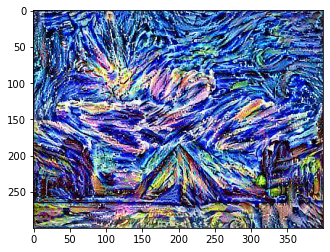

In [14]:
show = tf.io.read_file("./" + str("output") + ".jpg")

show = tf.image.decode_jpeg(show, channels=3)

plt.imshow(show)